## 요약
- 비중고도서 목록과 중고도서 목록, 2 파일을 관리하기로 결정
    - 비중고도서 ItemId를 기준으로 각 중고정보 페이지를 접근하여 크롤링
        - 비중고도서 베스트셀러 url
            - ``https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={year}&Month={month}&Week={week}&page={page}&cnt=1000&SortOrder=1``
        - 비중고도서 페이지 url
            - ```https://www.aladin.co.kr/shop/wproduct.aspx?ItemId={}```
        - 중고정보 페이지 url
            -```https://www.aladin.co.kr/shop/UsedShop/wuseditemall.aspx?ItemId={}&TabType=3&Fix=1``` 
        - ItemId에 규칙이 따로 없는 것으로 추정
    - 비중고도서 목록에는 각 도서별 정보 (ItemId, 도서명, 저자, 출판사, 세일즈포인트 등)
    - 중고도서 목록에는 각 매물 별 정보 (책이름, ItemId, 중고등급, 판매가, 할인율)
- 비중고도서 목록
    - 각 주차별 베스트셀러 목록을 xls로 제공받은 뒤 concat
    - 구분 : '국내도서' 중 저자, 출판사, 대분류가 null이 아닌 경우만 추려서 사용
        - 상품 굿즈 등이 포함되어있음
        - 도서명 nlp할 것 감안하면 국내도서로 좁히는 것 도움 됨
        - 국내도서 분류에 머그컵 등이 있는 경우가 있어서, 우선 저자, 출판사, 대분류가 공란이 아닌 것들만 추림
        - 만약 대분류가 공란인 것을 차후에 사용하고자 한다면
            - manually 보간하면 될 듯 
        - 만약 저자, 출판사가 공란인 데이터를 사용하고자 한다면
            - 편집자, 편집부로 fillna 가능할 수 있음 (확인 필요)
    - ItemId 기준 중복 정리
    - ItemId 기준 keep=last로 해서 중복 제거
    - 부정확할 수 있는 정보는 이후 크롤링해서 체크 후 업데이트 하는 것으로
        - 저자가 복수일 때 양식이 통일되지 않음
            - 다음 두 양식이 혼용
            1. AA, BB, CC 지음
            2. AA 외 지음
        - SalesPoint는 이후에는 crawling해서 확인하는 걸로
            - 매일 업데이트 되기 때문에 도서별 정보가 다소 다를 수 있음


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [6]:
# 필요한 패키지 import
from bs4 import BeautifulSoup
import requests
import re
import os, natsort

In [11]:
PRJCT_PATH = 'C:\\Users\junsung\KDH_AI_DEV\project2\\aladin\\aladin_usedbook'

## 개요
- 국내 중고 도서 중 우주점 항목 페이지
  - https://www.aladin.co.kr/search/wsearchresult.aspx?SearchTarget=Used&KeyRecentPublish=0&OutStock=0&ViewType=Detail&SortOrder=11&CustReviewCount=0&CustReviewRank=0&KeyWord=&CategorySearch=55890%2C170%2C76001%2C2105%2C987%2C4395%2C8257%2C2551%2C798%2C1%2C1383%2C1108%2C55889%2C1196%2C74%2C517%2C1322%2C1230%2C13789%2C656%2C336%2C2913%2C1237%2C2030%2C76000%2C1137%2C50246%2C351%2C0%400&chkKeyTitle=&chkKeyAuthor=&chkKeyPublisher=&IsDirectDelivery=2&ViewRowCount=50&SuggestKeyWord=
- url 구조 :
  - 도서 판매 페이지
    - 예시: https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=341311231
    - book id의 규칙은 잘 모르겠음
    - 책 제목에 \[중고\]가 있는 것으로 명확히 구분 가능
    - 품절도서/ 중고도서/ 일반도서의 페이지 구조가 다름
      - 품절도서 : 중고 모두보기가 있음
      - 중고도서 : 중고 모두보기가 있음, 새상품 상세보기 있음
      - 일반도서 : 위 두 사항 모두 해당 없음
  - 중고 정보 페이지
    - 예시 : https://www.aladin.co.kr/shop/UsedShop/wuseditemall.aspx?ItemId=329596&TabType=3&Fix=1
    - 새상품의 itemid / ``tabtype=3`` : 우주점 
    - 만약 itemid에 중고상품 아이디가 들어가면 중고상품의 중고상품 (즉 존재하지 않음)
    - 중고상품이 없는 item id가 들어가도 빈 페이지로 보임
- 어떻게 접근할 것인가?
    - 중고 접근 페이지 경유
    - 일반도서 itemid 수집 (방법 검색해보기) 이후 중고 정보 페이지 접근
    - 임의의 페이지 접근 후 페이지 유형에 따라 프로세스 진행
      - 새상품 상세보기가 없는 경우 : 중고 정보 페이지로 접근
      - 새상품 상세보기가 있는 경우 : 새상품 페이지의 링크에서 item id를 수집 후 중고 정보 페이지로 접근
      - 중고 정보 페이지에서 일괄 적으로 링크 수집
      - 이후 수집된 링크에 접근

- 중고 도서 판매 페이지 구조
  - 분류 : 알라딘 직접 배송/ 우주점 / 판매자 배송
    - selector : ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_label_wrap > span```
    - class가 bluebox, orangebox, greenbox
  - 필요한 정보
    - 도서 명, 저자, 출판사, 출판일시
      - 도서명 앞에 \[\]로 특수한 정보가 들어있을 수 있음을 주의
      - 도서 맨 뒤에 권 번호 등의 정보가 있을 수 있음을 주의
    - 정가, 정가대비 할인율
    - 중고 품질 등급
    - 새상품 관련 정보
      - 절판 도서는 SalesPoint가 없을 수 있음
        - 절판된 구판은 개정판 보기 링크 있음
        - 개정판에서도 구판으로 가는 링크 있음
      - 세트는 별도의 SalesPoint가 있음
      - isbn을 활용할 수 있음 


- DB를 두개 만드는 것도 좋을 듯
  - 새 상품 정보
    - 도서명, 저자, 출판사, 출판일시
    - 정가, 도서 분류, 세일즈 포인트, 절판 여부
  - 중고 상품 정보
    - 새 상품 id, 등급, 판매가
      - 정가보다 비쌀 경우 할인율이 안적혀 있을 수 있음 주의
      - 특히 판매자 중고의 경우 할인율이 일관적으로 적혀있지 않음
      - 할인율을 별도로 계산할 필요 있음 

**베스트 셀러 페이지**
- url 형식 : ``f'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={year}&Month={month}&Week={week}&page={page}&cnt=1000&SortOrder=1'``
    - year : 2000~2024
    - month : 1~12
    - week : 1~ 5
        - 2월도 week 5 존재
    - page : 1~20
    - 연도가 앞으로 갈수록 품절도서 확률 높아짐
    - 현재 2024.07 2nd week까지 있음
    - xls 파일 다운로드 가능
        - itemid 포함되어 있음
        - 저자, 상품명, 출판사, 정가, SalesPoint, 대표분류
        - 저자 정보 업데이트를 위한 경우를 제외하고는 xls의 정보 사용하면 될 듯
            - 동명이인 처리 등의 업데이트

**정해진 프로세스**

0. 임의의 연/월/주를 10개 골라서 itemid 목록 작성
1. 임의의 새 상품 페이지를 들어간다
2. 새 상품 관련 정보 수집
3. 해당 도서의 중고 정보 페이지로 접근
4. 각 도서별 중고 상품 정보 수집

In [6]:
size = 10
year_cand = range(2000,2025)
month_cand = range(1,13)
week_cand = range(1,6)
page_cand = range(1,21)

years = np.random.choice(year_cand,size)
months = np.random.choice(month_cand,size)
weeks = np.random.choice(week_cand,size)
#어차피 전체 페이지의 내용이 다운되기 때문에 페이지는 상관 없긴 함
pages= np.random.choice(page_cand,size)

url_format = 'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={}&Month={}&Week={}&page={}&cnt=1000&SortOrder=1'

for y,m,w,p in zip(years,months,weeks,pages):
    print(url_format.format(y,m,w,p))

https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2011&Month=5&Week=5&page=4&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2021&Month=4&Week=3&page=17&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2005&Month=7&Week=1&page=20&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2002&Month=2&Week=1&page=18&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2017&Month=10&Week=4&page=20&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2000&Month=9&Week=5&page=3&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2014&Month=11&Week=5&page=9&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.asp

위 url 링크에 들어가면 도서목록의 우측 상단에 xls로 다운 받는 링크 있음

xls 파일 다운 받은 뒤, csv 파일로 변경하여 사용

In [18]:
dir_path = os.path.join(PRJCT_PATH,'csv')
files = os.listdir(dir_path)
files = natsort.natsorted(files)

df_dict = dict()
for file in files:
    if file[-3:] != 'csv':
        continue
    info = file.split('_')[0]
    file_path = os.path.join(dir_path, file)
    try:
        df_temp = pd.read_csv(file_path, on_bad_lines='skip')  # Use on_bad_lines='skip' instead of error_bad_lines=False
        df_temp['source'] = info
        df_dict[info] = df_temp
    except pd.errors.ParserError as e:
        print(f"Error parsing {file}: {e}")


['2000년1월1주_20240710.csv',
 '2000년1월2주_20240710.csv',
 '2000년1월3주_20240710.csv',
 '2000년1월4주_20240710.csv',
 '2000년1월5주_20240710.csv',
 '2000년2월1주_20240710.csv',
 '2000년2월2주_20240710.csv',
 '2000년2월3주_20240710.csv',
 '2000년2월4주_20240710.csv',
 '2000년2월5주_20240710.csv',
 '2000년3월1주_20240710.csv',
 '2000년3월2주_20240710.csv',
 '2000년3월3주_20240710.csv',
 '2000년3월4주_20240710.csv',
 '2000년3월5주_20240710.csv',
 '2000년4월1주_20240710.csv',
 '2000년4월2주_20240710.csv',
 '2000년4월3주_20240710.csv',
 '2000년4월4주_20240710.csv',
 '2000년4월5주_20240710.csv',
 '2000년5월1주_20240710.csv',
 '2000년5월2주_20240710.csv',
 '2000년5월3주_20240710.csv',
 '2000년5월4주_20240710.csv',
 '2000년5월5주_20240710.csv',
 '2000년6월1주_20240710.csv',
 '2000년6월2주_20240710.csv',
 '2000년6월3주_20240710.csv',
 '2000년6월4주_20240710.csv',
 '2000년6월5주_20240710.csv',
 '2000년7월1주_20240710.csv',
 '2000년7월2주_20240710.csv',
 '2000년7월3주_20240710.csv',
 '2000년7월4주_20240710.csv',
 '2000년7월5주_20240710.csv',
 '2000년8월1주_20240710.csv',
 '2000년8월2주_20240710.csv',
 

In [19]:
df_whole = pd.concat(list(df_dict.values()))
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1415660 entries, 0.0 to 999.0
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   순번/순위       1415654 non-null  float64
 1   구분          1415553 non-null  object 
 2   상품명         1415553 non-null  object 
 3   ItemId      1415654 non-null  float64
 4   ISBN13      1402025 non-null  object 
 5   부가기호        1225118 non-null  object 
 6   저자/아티스트     1412982 non-null  object 
 7   출판사/제작사     1415030 non-null  object 
 8   출간일         1415654 non-null  float64
 9   정가          1415654 non-null  object 
 10  판매가         1415654 non-null  object 
 11  마일리지        1415654 non-null  object 
 12  세일즈포인트      1415654 non-null  float64
 13  대표분류(대분류명)  1410412 non-null  object 
 14  source      1415660 non-null  object 
dtypes: float64(4), object(11)
memory usage: 172.8+ MB


In [20]:
col = '순번/순위'
df_whole[df_whole[col].isna()]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008년10월5주
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008년11월1주
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012년9월2주
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012년11월1주
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014년12월3주
NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017년12월3주


In [21]:
df_temp = df_whole.dropna(axis=0,how='any',subset=[col])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1415654 entries, 0.0 to 999.0
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   순번/순위       1415654 non-null  float64
 1   구분          1415547 non-null  object 
 2   상품명         1415547 non-null  object 
 3   ItemId      1415654 non-null  float64
 4   ISBN13      1402025 non-null  object 
 5   부가기호        1225118 non-null  object 
 6   저자/아티스트     1412982 non-null  object 
 7   출판사/제작사     1415030 non-null  object 
 8   출간일         1415654 non-null  float64
 9   정가          1415654 non-null  object 
 10  판매가         1415654 non-null  object 
 11  마일리지        1415654 non-null  object 
 12  세일즈포인트      1415654 non-null  float64
 13  대표분류(대분류명)  1410412 non-null  object 
 14  source      1415654 non-null  object 
dtypes: float64(4), object(11)
memory usage: 172.8+ MB


In [22]:
import functools

cond1 = df_temp['저자/아티스트'].isna()
cond2 = df_temp['출판사/제작사'].isna()
cond3 = df_temp['대표분류(대분류명)'].isna()

cond = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_temp[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
52.0,53.0,국내도서,메밀꽃 필 무렵,48878.0,NaN,NaN,이효석,삼중당,19831101.0,"2,000","1,800",100점,17.0,NaN,2000년1월1주
80.0,81.0,국내도서,디지털 IC 회로 설계,42798.0,NaN,NaN,김응욱,세화(도서출판),19870301.0,"6,000","5,400",300점,14.0,NaN,2000년1월1주
159.0,160.0,국내도서,사회조사분석사 2급,214650.0,9788941461005.0,NaN,I&T 컨설팅 엮음,박문각,19991201.0,"15,000","13,500",750점,13.0,NaN,2000년1월1주
261.0,262.0,국내도서,있잖아 하고 싶은 말이 있거든,122952.0,NaN,NaN,최유수,새벽,19950701.0,"3,000","2,700",150점,12.0,NaN,2000년1월1주
311.0,312.0,국내도서,동작 해부학,41454.0,NaN,NaN,ROLF WIRHED,형설출판사,19940201.0,"13,500","13,500",400점,12.0,NaN,2000년1월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812.0,813.0,국내도서,페가콘의 희로애락 스티커북,331145343.0,9791136780768.0,NaN,NaN,서울미디어코믹스(서울문화사),20231228.0,"20,000","18,000","1,000점",1492.0,만화,2024년1월2주
532.0,533.0,국내도서,[아카데미] 정희진 : 피해자 중심주의의 문제 (4월 30일 오후 7시),336917203.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240430.0,"15,000","15,000",0점,410.0,NaN,2024년4월2주
549.0,550.0,국내도서,"[아카데미] 정희진 : 성매매, 폭력인가 노동인가 (5월 7일 오후 7시)",336917521.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240507.0,"15,000","15,000",0점,470.0,NaN,2024년4월2주
585.0,586.0,국내도서,[아카데미] 정희진 : 신자유주의 통치와 페미니즘 (5월 14일 오후 7시),336917737.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240514.0,"15,000","15,000",0점,490.0,NaN,2024년4월2주


In [23]:
display(df_temp['구분'].unique())
cond = df_temp['구분'] == '국내도서'
df_kor=df_temp[cond]
df_kor.info()

array(['국내도서', '외국도서', nan, '음반', '증정품', '알라딘굿즈', 'eBook'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
Index: 1402518 entries, 0.0 to 999.0
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   순번/순위       1402518 non-null  float64
 1   구분          1402518 non-null  object 
 2   상품명         1402518 non-null  object 
 3   ItemId      1402518 non-null  float64
 4   ISBN13      1389965 non-null  object 
 5   부가기호        1221953 non-null  object 
 6   저자/아티스트     1401376 non-null  object 
 7   출판사/제작사     1402439 non-null  object 
 8   출간일         1402518 non-null  float64
 9   정가          1402518 non-null  object 
 10  판매가         1402518 non-null  object 
 11  마일리지        1402518 non-null  object 
 12  세일즈포인트      1402518 non-null  float64
 13  대표분류(대분류명)  1398369 non-null  object 
 14  source      1402518 non-null  object 
dtypes: float64(4), object(11)
memory usage: 171.2+ MB


In [24]:
import functools

cond1 = df_kor['저자/아티스트'].isna()
cond2 = df_kor['출판사/제작사'].isna()
cond3 = df_kor['대표분류(대분류명)'].isna()

cond_na = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_kor[cond_na]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
52.0,53.0,국내도서,메밀꽃 필 무렵,48878.0,NaN,NaN,이효석,삼중당,19831101.0,"2,000","1,800",100점,17.0,NaN,2000년1월1주
80.0,81.0,국내도서,디지털 IC 회로 설계,42798.0,NaN,NaN,김응욱,세화(도서출판),19870301.0,"6,000","5,400",300점,14.0,NaN,2000년1월1주
159.0,160.0,국내도서,사회조사분석사 2급,214650.0,9788941461005.0,NaN,I&T 컨설팅 엮음,박문각,19991201.0,"15,000","13,500",750점,13.0,NaN,2000년1월1주
261.0,262.0,국내도서,있잖아 하고 싶은 말이 있거든,122952.0,NaN,NaN,최유수,새벽,19950701.0,"3,000","2,700",150점,12.0,NaN,2000년1월1주
311.0,312.0,국내도서,동작 해부학,41454.0,NaN,NaN,ROLF WIRHED,형설출판사,19940201.0,"13,500","13,500",400점,12.0,NaN,2000년1월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812.0,813.0,국내도서,페가콘의 희로애락 스티커북,331145343.0,9791136780768.0,NaN,NaN,서울미디어코믹스(서울문화사),20231228.0,"20,000","18,000","1,000점",1492.0,만화,2024년1월2주
532.0,533.0,국내도서,[아카데미] 정희진 : 피해자 중심주의의 문제 (4월 30일 오후 7시),336917203.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240430.0,"15,000","15,000",0점,410.0,NaN,2024년4월2주
549.0,550.0,국내도서,"[아카데미] 정희진 : 성매매, 폭력인가 노동인가 (5월 7일 오후 7시)",336917521.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240507.0,"15,000","15,000",0점,470.0,NaN,2024년4월2주
585.0,586.0,국내도서,[아카데미] 정희진 : 신자유주의 통치와 페미니즘 (5월 14일 오후 7시),336917737.0,NaN,NaN,정희진 강의,알라딘 이벤트,20240514.0,"15,000","15,000",0점,490.0,NaN,2024년4월2주


**결측치**
- 상품 페이지부터 저자/대표분류 등이 누락된 경우가 많음
    - 하지만 상품 페이지에 있지만 csv에 없는 경우도 있음
- 국내 도서에 CD, 사은품, 종로점 머그컵이 포함되어있는 경우
    - 도서 명에서 앞의 \[\], 뒤의 ()를 따로 분리할 필요 있음
    - 출판사가 nan이 아닌데도 상품이 있을지는 확인해볼 필요 있음

In [25]:
display(df_kor['대표분류(대분류명)'].unique())

array(['에세이', '종교/역학', '자기계발', '소설/시/희곡', '사회과학', '인문학', '외국어', '컴퓨터/모바일',
       '여행', '경제경영', '역사', '고전', '좋은부모', '건강/취미', '과학', nan, '예술/대중문화',
       '만화', '청소년', '요리/살림', '대학교재/전문서적', '수험서/자격증', '일본 도서', '달력/기타',
       '교육/자료', '전집/중고전집', '청소년_추천도서', '유아', '어린이'], dtype=object)

In [26]:
cond = df_kor['대표분류(대분류명)'] == '달력/기타'
df_kor[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
781.0,782.0,국내도서,산에는 꽃이 피네 (오디오북),188072.0,9788985193986.0,3810.0,법정 지음,동쪽나라(=한민사),19980602.0,"9,000","8,100",450점,120.0,달력/기타,2000년8월3주
628.0,629.0,국내도서,꿈 2001,253949.0,9788985772372.0,NaN,호영 편집부 엮음,호영,20000905.0,"9,000","8,100",450점,15.0,달력/기타,2000년12월3주
473.0,474.0,국내도서,영어공부 절대로 하지 마라 - 테이프 2개,261158.0,9788989491033.0,NaN,"정찬용 지음, 북텔러",오디세이닷컴,20001201.0,"7,000","6,300",350점,55.0,달력/기타,2001년5월1주
847.0,848.0,국내도서,영어공부 절대로 하지 마라 - 테이프 2개,261158.0,9788989491033.0,NaN,"정찬용 지음, 북텔러",오디세이닷컴,20001201.0,"7,000","6,300",350점,55.0,달력/기타,2001년5월2주
788.0,789.0,국내도서,영어공부 절대로 하지 마라 - 테이프 2개,261158.0,9788989491033.0,NaN,"정찬용 지음, 북텔러",오디세이닷컴,20001201.0,"7,000","6,300",350점,55.0,달력/기타,2001년6월4주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406.0,407.0,국내도서,2019 문재인 대통령 벽걸이 달력,177285792.0,8809529010420.0,1,더휴먼 편집부 지음,더휴먼,20190107.0,"9,800","8,820",490점,190.0,달력/기타,2019년1월1주
285.0,286.0,국내도서,2019 문재인 대통령 탁상 달력,176184502.0,8809529010413.0,1,더휴먼 편집부 지음,더휴먼,20181224.0,"6,500","5,850",320점,2419.0,달력/기타,2019년1월2주
533.0,534.0,국내도서,2019 문재인 대통령 탁상 달력,176184502.0,8809529010413.0,1,더휴먼 편집부 지음,더휴먼,20181224.0,"6,500","5,850",320점,2419.0,달력/기타,2019년1월3주
630.0,631.0,국내도서,2019 문재인 대통령 탁상 달력,176184502.0,8809529010413.0,1,더휴먼 편집부 지음,더휴먼,20181224.0,"6,500","5,850",320점,2419.0,달력/기타,2019년1월4주


- 지금 단계에서는 이하에 대해 drop해도 될것으로 판단
    - 저자/ 출판사/ 분류가 결측치인 것
- 분류 : '달력/기타'는 제외하지 않는 것으로 결정

In [27]:
df_filtered = df_kor[~cond_na]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397346 entries, 0.0 to 999.0
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   순번/순위       1397346 non-null  float64
 1   구분          1397346 non-null  object 
 2   상품명         1397346 non-null  object 
 3   ItemId      1397346 non-null  float64
 4   ISBN13      1386074 non-null  object 
 5   부가기호        1219573 non-null  object 
 6   저자/아티스트     1397346 non-null  object 
 7   출판사/제작사     1397346 non-null  object 
 8   출간일         1397346 non-null  float64
 9   정가          1397346 non-null  object 
 10  판매가         1397346 non-null  object 
 11  마일리지        1397346 non-null  object 
 12  세일즈포인트      1397346 non-null  float64
 13  대표분류(대분류명)  1397346 non-null  object 
 14  source      1397346 non-null  object 
dtypes: float64(4), object(11)
memory usage: 170.6+ MB


In [28]:
(df_filtered['ItemId'].apply(lambda x: type(x))).value_counts()

ItemId
<class 'float'>    1397346
Name: count, dtype: int64

In [29]:
(df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts()

ISBN13
<class 'float'>    1034743
<class 'str'>       304492
<class 'int'>        58111
Name: count, dtype: int64

In [30]:
(df_filtered['정가'].apply(lambda x: type(x))).value_counts()

정가
<class 'str'>    1397346
Name: count, dtype: int64

- ISBN13 int로 통일
- 출간일, 정가, 판매가 각각 datetime, int로 변환 

In [31]:
cond = ~ (df_filtered['ISBN13'].isna())
temp = pd.to_numeric(df_filtered.loc[cond,'ISBN13'], errors='coerce')
cond2 = ~temp.isna()
temp[cond2] = temp[cond2].astype(int).astype(str)
df_filtered.loc[cond,'ISBN13']=temp.fillna(df_filtered.loc[cond,'ISBN13'])
display((df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts())
display(df_filtered.loc[df_filtered['ISBN13'].apply(type)==float,'ISBN13'].unique())

MemoryError: Unable to allocate 14.4 GiB for an array with shape (1929691708,) and data type int64

메모리 과부하 문제로 청크로 처리.
for 루프는 chunk_size를 기준으로 DataFrame을 더 작은 부분으로 나눕니다.

In [32]:
def process_isbn13(df):
    cond = ~df['ISBN13'].isna()
    temp = pd.to_numeric(df.loc[cond, 'ISBN13'], errors='coerce')
    cond2 = ~temp.isna()
    temp.loc[cond2] = temp.loc[cond2].astype(np.int64).astype(str)  # Use np.int64 for memory efficiency
    df.loc[cond, 'ISBN13'] = temp.fillna(df.loc[cond, 'ISBN13'])
    return df

# Process in chunks if df_filtered is too large
chunk_size = 100000  # Adjust chunk size based on available memory
chunks = []

for start in range(0, len(df_filtered), chunk_size):
    end = start + chunk_size
    chunk = df_filtered.iloc[start:end].copy()
    chunk = process_isbn13(chunk)
    chunks.append(chunk)

df_filtered_processed = pd.concat(chunks, ignore_index=True)

# Displaying the results for verification
display((df_filtered_processed['ISBN13'].apply(lambda x: type(x))).value_counts())
display(df_filtered_processed.loc[df_filtered_processed['ISBN13'].apply(type) == float, 'ISBN13'].unique())

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\2601955549.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['9788932902562' '9788985599214' '9788973372843' ... '9788970638331'
 '9788932903804' '9788986361438']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp.loc[cond2] = temp.loc[cond2].astype(np.int64).astype(str)  # Use np.int64 for memory efficiency
C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\2601955549.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['9788995242407' '9788988375716' '9788937402883' ... '9788936430467'
 '9788955611953' '9788988739235']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp.loc[cond2] = temp.loc[cond2].astype(np.int64).astype(str)  # Use np.int64 for memory efficiency
C:\Users\jun

ISBN13
<class 'str'>      1386074
<class 'float'>      11272
Name: count, dtype: int64

array([nan], dtype=object)

In [33]:
col = '정가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
df_filtered[col] = temp

정가
<class 'str'>    1397346
Name: count, dtype: int64

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\2800204521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\2800204521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font fami

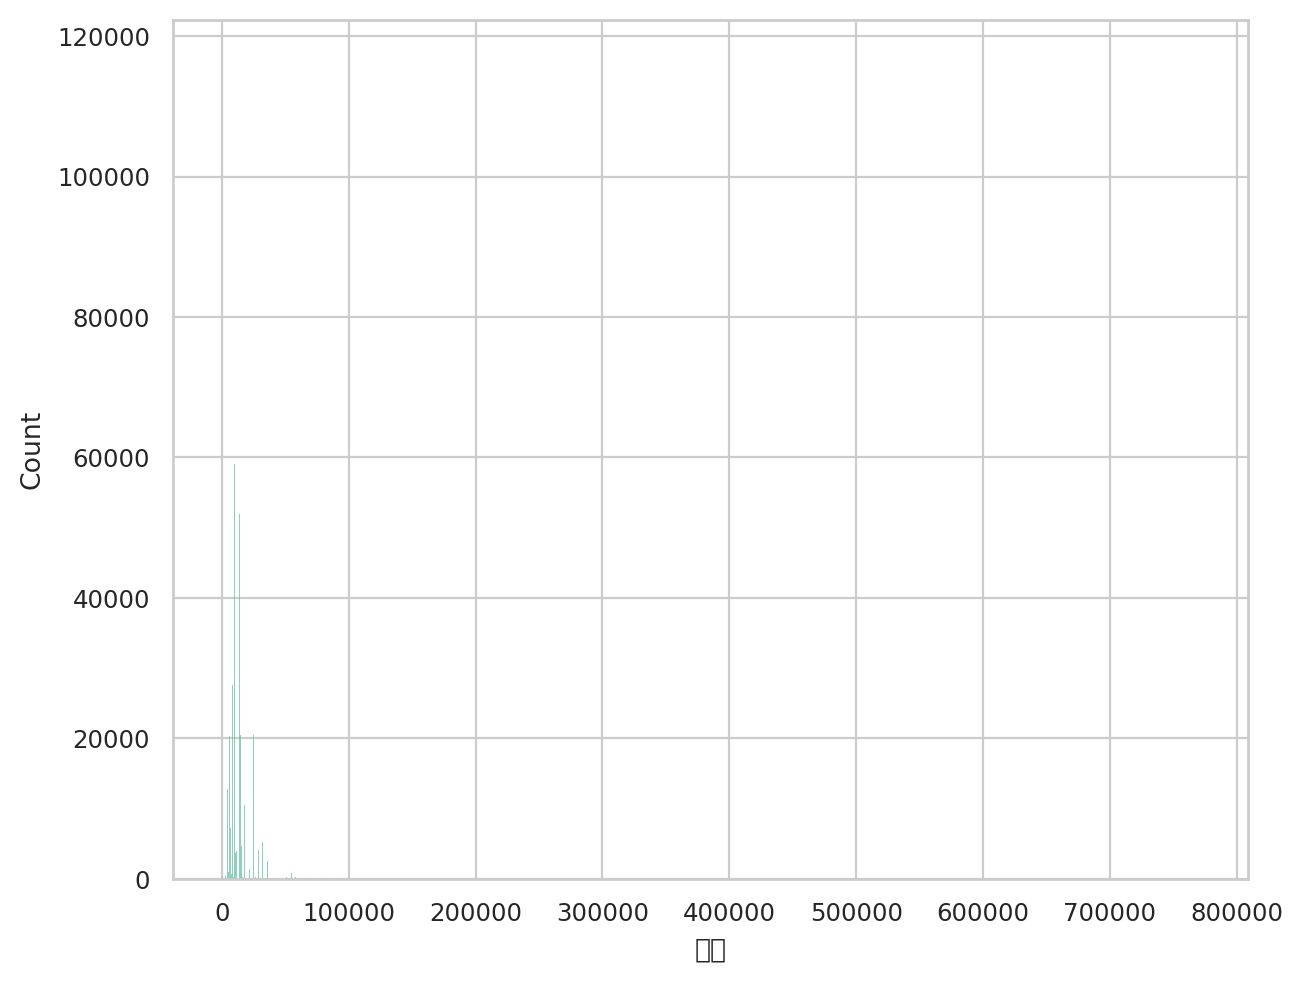

In [34]:
sns.histplot(df_filtered[col]);

판매가
<class 'str'>    1397346
Name: count, dtype: int64

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\659068920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  func(*args, **kwargs)
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current f

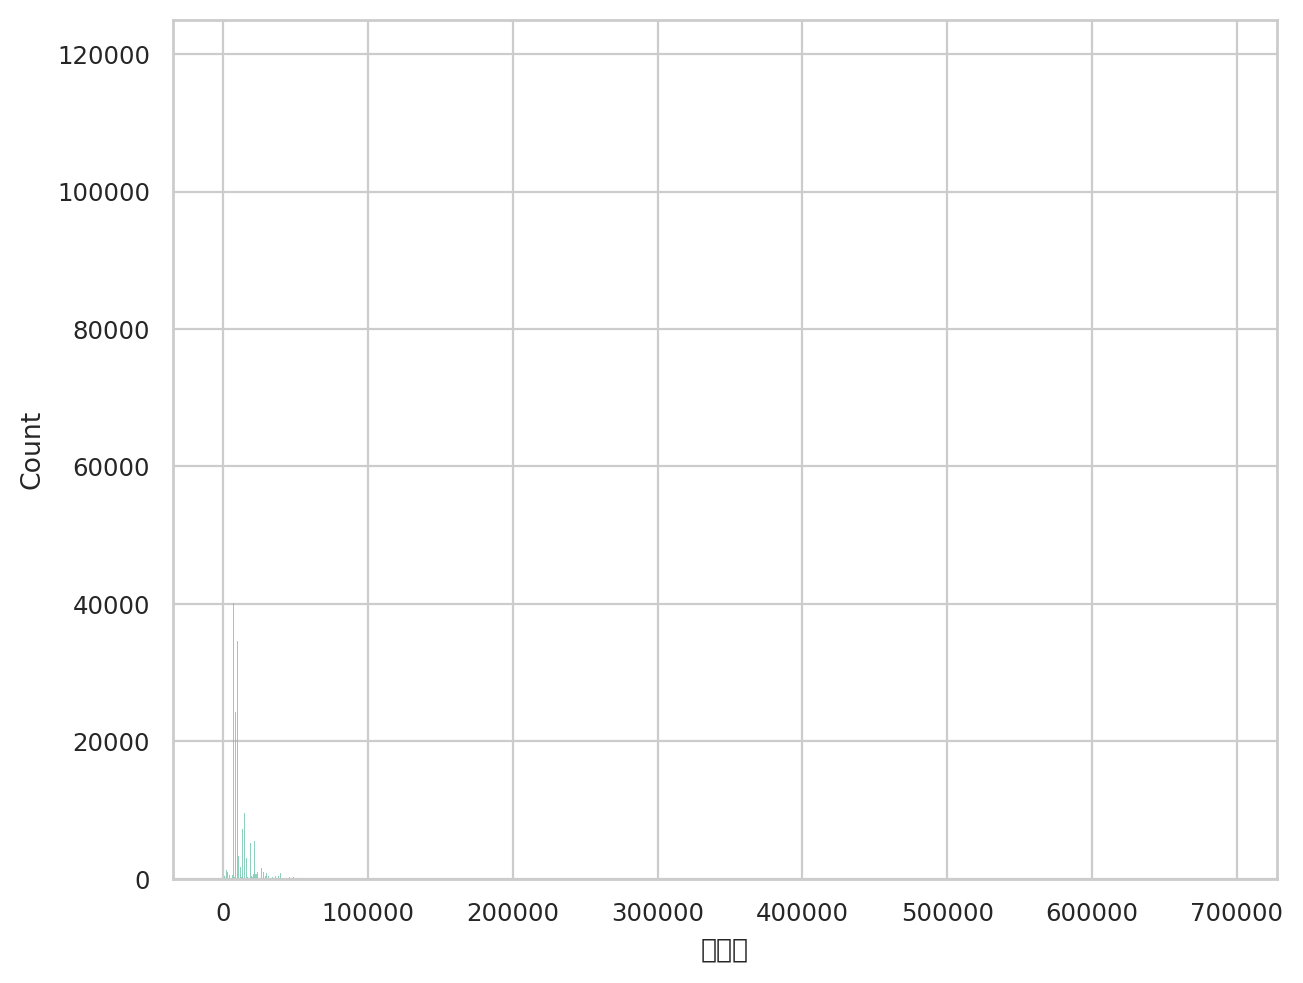

In [35]:
col = '판매가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
sns.histplot(temp);

In [36]:
df_filtered[col] = temp

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


출간일
<class 'float'>    1397346
Name: count, dtype: int64

0

findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
findfont: Font family 'D2Coding' not found.
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  func(*args, **kwargs)
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\junsung\.conda\envs\devel\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  func(*args, **kwargs)
findfont: Font 

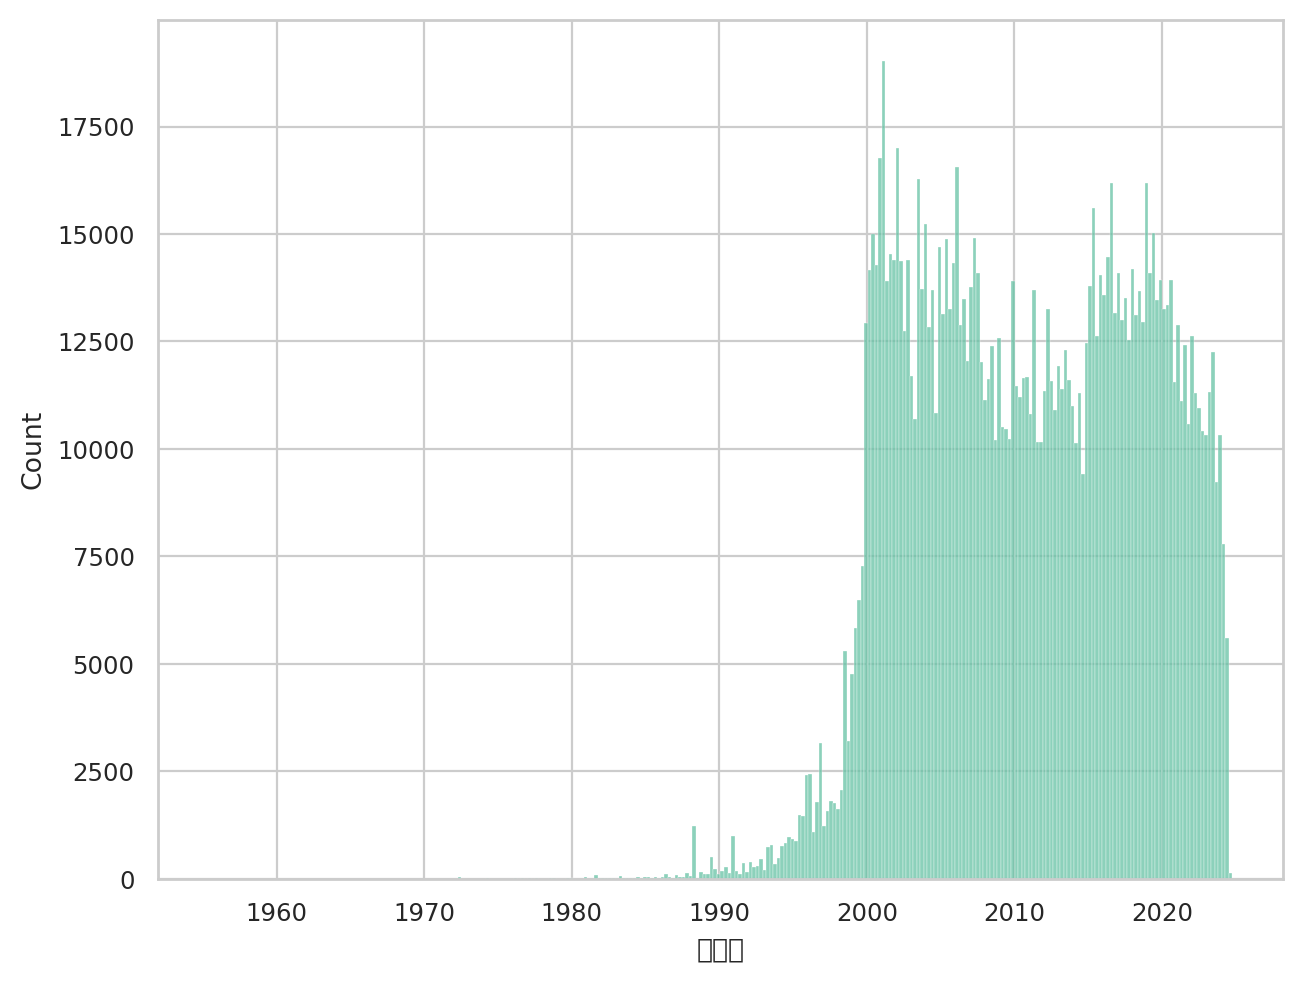

In [37]:
col = '출간일'
display(df_filtered[col].apply(type).value_counts())
temp = df_filtered[col].astype(int).astype(str)
temp = pd.to_datetime(temp,format='%Y%m%d')
sns.histplot(temp);
display(np.sum(temp.isna()))

In [38]:
df_filtered[col] = temp

C:\Users\junsung\AppData\Local\Temp\ipykernel_23812\3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


### 중복 확인

In [39]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397346 entries, 0.0 to 999.0
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   순번/순위       1397346 non-null  float64       
 1   구분          1397346 non-null  object        
 2   상품명         1397346 non-null  object        
 3   ItemId      1397346 non-null  float64       
 4   ISBN13      1386074 non-null  object        
 5   부가기호        1219573 non-null  object        
 6   저자/아티스트     1397346 non-null  object        
 7   출판사/제작사     1397346 non-null  object        
 8   출간일         1397346 non-null  datetime64[ns]
 9   정가          1397346 non-null  int64         
 10  판매가         1397346 non-null  int64         
 11  마일리지        1397346 non-null  object        
 12  세일즈포인트      1397346 non-null  float64       
 13  대표분류(대분류명)  1397346 non-null  object        
 14  source      1397346 non-null  object        
dtypes: datetime64[ns](1), float64(3), int

In [40]:
len(df_filtered['ItemId'].unique())

158100

In [41]:
df_filtered[df_filtered[['상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가','ISBN13']].duplicated(keep=False)]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
0.0,1.0,국내도서,세상의 바보들에게 웃으면서 화내는 방법,208008.0,9788932902562.0,3860.0,"움베르토 에코 지음, 이세욱 옮김",열린책들,1999-10-10,9500,8550,470점,2695.0,에세이,2000년1월1주
1.0,2.0,국내도서,오두막 편지,215589.0,9788985599214.0,NaN,법정 지음,이레,1999-12-15,7000,6300,350점,1922.0,종교/역학,2000년1월1주
2.0,3.0,국내도서,잠자는 아이디어 깨우기,212072.0,9788973372843.0,3840.0,"잭 포스터 지음, 정상수 옮김",해냄,1999-11-20,8000,7200,400점,267.0,자기계발,2000년1월1주
3.0,4.0,국내도서,해리 포터와 마법사의 돌 1 (무선),210689.0,9788983920683.0,4840.0,"조앤 K. 롤링 지음, 김혜원 옮김",문학수첩,1999-11-19,8000,7200,400점,20442.0,소설/시/희곡,2000년1월1주
4.0,5.0,국내도서,해리 포터와 비밀의 방 1 (무선),216131.0,9788983920706.0,4840.0,"조앤 K. 롤링 지음, 김혜원 옮김",문학수첩,1999-12-20,8000,7200,400점,16978.0,소설/시/희곡,2000년1월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993.0,994.0,국내도서,야노 군의 평범한 나날 7,341219496.0,9791141134341,NaN,타무라 유이 지음,학산문화사(만화),2024-06-13,6000,5400,300점,4380.0,만화,2024년7월2주
994.0,995.0,국내도서,블루 록 24,339277637.0,9791141124342,NaN,"노무라 유스케 지음, 카네시로 무네유키 원작",학산문화사(만화),2024-05-09,6000,5400,300점,4365.0,만화,2024년7월2주
996.0,997.0,국내도서,어두운 물,341327066.0,9791166836008,03810,전건우 지음,&(앤드),2024-06-26,15000,13500,750점,3070.0,소설/시/희곡,2024년7월2주
997.0,998.0,국내도서,자유의 가격,341940640.0,9791170800514,03810,신미경 지음,뜻밖,2024-07-03,17000,15300,850점,3030.0,에세이,2024년7월2주


In [44]:
df_filtered[df_filtered['ItemId'].duplicated(keep=False)].sort_values(by='ItemId')

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
932.0,933.0,국내도서,0시를 향하여,17.0,9788938202031.0,34840.0,"애거서 크리스티 지음, 이가형 옮김",해문출판사,1989-12-01,6000,5400,300점,1175.0,소설/시/희곡,2001년10월4주
202.0,203.0,국내도서,0시를 향하여,17.0,9788938202031.0,34840,"애거서 크리스티 지음, 이가형 옮김",해문출판사,1989-12-01,6000,5400,300점,1175.0,소설/시/희곡,2021년1월3주
798.0,799.0,국내도서,0시를 향하여,17.0,9788938202031.0,34840.0,"애거서 크리스티 지음, 이가형 옮김",해문출판사,1989-12-01,6000,5400,300점,1175.0,소설/시/희곡,2002년7월4주
419.0,420.0,국내도서,10가지 충고 5,136.0,9788983360250.0,NaN,편집부,쪽지,1998-05-15,1500,1350,70점,34.0,청소년,2000년12월4주
935.0,936.0,국내도서,10가지 충고 5,136.0,9788983360250.0,NaN,편집부,쪽지,1998-05-15,1500,1350,70점,34.0,청소년,2002년4월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844.0,845.0,국내도서,의매생활 7,342182342.0,9791127876531,04830,"미카와 고스트 지음, Hiten 그림, 박경용 옮김",디앤씨미디어(주)(D&C미디어),2024-07-10,8500,7650,420점,6210.0,소설/시/희곡,2024년7월1주
595.0,596.0,국내도서,마법소녀 이세계아이돌 1,342182604.0,9791193821107,07810,"머클 지음, 갈가알 그림",디앤씨미디어(주)(D&C미디어),2024-05-31,12000,10800,600점,2040.0,만화,2024년6월5주
595.0,596.0,국내도서,마법소녀 이세계아이돌 1,342182604.0,9791193821107,07810,"머클 지음, 갈가알 그림",디앤씨미디어(주)(D&C미디어),2024-05-31,12000,10800,600점,2040.0,만화,2024년7월1주
619.0,620.0,국내도서,마법소녀 이세계아이돌 2,342182727.0,9791193821114,07810,"머클 지음, 갈가알 그림",디앤씨미디어(주)(D&C미디어),2024-05-31,12000,10800,600점,2010.0,만화,2024년6월5주


In [45]:
cond1= df_filtered['ItemId'].duplicated(keep=False)
cond2= df_filtered[['ItemId','세일즈포인트']].duplicated(keep=False)
df_filtered[cond1&(~cond2)].sort_values(by=['ItemId','세일즈포인트'])

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명),source
886.0,887.0,국내도서,걸리버 여행기,7679.0,9788983920775.0,03840,"조나단 스위프트 지음, 신현철 옮김",문학수첩,1992-07-07,10000,9000,500점,8615.0,소설/시/희곡,2019년9월2주
756.0,757.0,국내도서,교사입니까,14441.0,9788984240032.0,03230,하워드 G.핸드릭스,아가페문화사,2019-02-10,10000,9500,300점,625.0,종교/역학,2012년4월4주
532.0,533.0,국내도서,낯선 곳에서 나를 만나다,29756.0,9788933705001.0,3330.0,한국문화인류학회 엮음,일조각,2006-08-25,13000,13000,0점,4670.0,인문학,2012년12월4주
750.0,751.0,국내도서,너무도 쓸쓸한 당신,31220.0,9788936436520.0,3810.0,박완서 지음,창비,1998-12-15,13000,11700,650점,1386.0,소설/시/희곡,2011년1월5주
603.0,604.0,국내도서,논어집주,32955.0,9788972701866.0,93140.0,김혁제 엮음,명문당,2003-03-03,15000,13500,750점,638.0,대학교재/전문서적,2000년4월2주
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633.0,634.0,국내도서,끝나지 않는 노래,14335359.0,9788984315297.0,3810.0,최진영 지음,한겨레출판,2011-12-23,11000,9900,550점,1261.0,소설/시/희곡,2012년5월1주
918.0,919.0,국내도서,죽은 눈을 위한 송가,14339823.0,9788932022642,3810.0,이이체 지음,문학과지성사,2011-12-16,9000,8100,450점,1786.0,소설/시/희곡,2015년5월4주
712.0,713.0,국내도서,동에 번쩍 서에 번쩍 세계 지리 이야기,14757759.0,9788958285984.0,43980.0,조지욱 지음,사계절,2012-01-20,13800,12420,690점,2944.0,청소년,2012년3월4주
827.0,828.0,국내도서,사람풍경,15703332.0,9788996773207.0,4800.0,김형경 지음,사람풍경,2012-03-10,13800,12420,690점,7517.0,에세이,2012년3월3주


In [46]:
display(np.sum(df_filtered.loc[cond1&(~cond2),'ItemId'].value_counts() == 1))
cond = df_filtered.loc[cond1&(~cond2),'ItemId'].value_counts() == 1  # ItemId와 세일즈포인트의 조합이 중복되지 않은 행
ids = cond.index[cond]
display(ids)
df_filtered.loc[df_filtered['ItemId'].isin(ids),'ItemId'].value_counts()

128

Index([  255347.0, 11130209.0,   673132.0,   577131.0,   142245.0,    29756.0,
        8371107.0,   399977.0,   411525.0,   328257.0,
       ...
         559416.0,   429658.0,   597370.0,   986237.0,  7965527.0,   229355.0,
        7498220.0,  6038272.0,  6038302.0,   457440.0],
      dtype='float64', name='ItemId', length=128)

ItemId
229355.0      206
935745.0      131
283830.0      126
331403.0      119
394933.0      102
             ... 
3526287.0       3
2968868.0       3
477248.0        3
988511.0        3
11130209.0      3
Name: count, Length: 128, dtype: int64

- 예상보다는 중복이 많지 않음
- ItemId 중복 == '상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가' 중복
    - 위의 것들이 중복되지만 세일즈프인트가 중복되지 않는 케이스가 존재
    - 세일즈포인트, 판매가, 정가에 대해서 현재의 값과 대조 필요
        - 세일즈포인트의 경우, 업데이트 되는 시간대에 걸쳐서 파일들을 다운받았기 때문일 수 있음
- 저자 이름이 다 들어간 케이스와 '000 외'로 들어간 케이스를 어떻게 통일할지 차후에 정해야 함
- 저자 이름 전처리 필요
    - 지음, 엮음, 옮김, 감수 등으로 구별하는 것이 좋을 듯
    - 저자 : 지음 / 참여자 : (기타 담당) 으로 분리하는 것 필요
- pd.duplicated에서 한 번만 등장하는 itemid가 있는 것처럼 보이는 이유
    - 아마 cond1에서 3번 중복됐는데 cond2에는 2번 중복된 케이스 등으로 확인 됨

**결론**
- ItemId 기준 keep=last로 해서 중복 제거
- SalesPoint는 이후에는 crawling해서 확인하는 걸로

In [51]:
cond1= ~df_filtered['ItemId'].duplicated(keep='last')
df_rslt = df_filtered[cond1].sort_values(by=['출간일','ItemId'])

df_rslt.info()

save_dir = 'processed'
date = 240711
file_name = f'unused_filtered_{date}.csv'

df_rslt.to_csv(os.path.join(PRJCT_PATH,save_dir,file_name),index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 158100 entries, 634.0 to 27.0
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   순번/순위       158100 non-null  float64       
 1   구분          158100 non-null  object        
 2   상품명         158100 non-null  object        
 3   ItemId      158100 non-null  float64       
 4   ISBN13      155552 non-null  object        
 5   부가기호        129271 non-null  object        
 6   저자/아티스트     158100 non-null  object        
 7   출판사/제작사     158100 non-null  object        
 8   출간일         158100 non-null  datetime64[ns]
 9   정가          158100 non-null  int64         
 10  판매가         158100 non-null  int64         
 11  마일리지        158100 non-null  object        
 12  세일즈포인트      158100 non-null  float64       
 13  대표분류(대분류명)  158100 non-null  object        
 14  source      158100 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(9)
